In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

import torch
import torchio as tio
from torch.utils.data import DataLoader
from functions import *

In [3]:
metaData = pd.read_csv('metaDataTrain.csv')
metaDataClean = metaData.iloc
metaDataClean[81]

Id             82.000000
Category        4.000000
Height        183.000000
Weight         82.000000
ed_maxmean      3.891845
ed_stdmean      0.831695
ed_meanstd      0.764176
ed_std_std      0.169425
ed_mean         2.713456
ed_max          6.324555
es_maxmean      6.307518
es_stdmean      1.379228
es_meanstd      1.190413
es_std_std      0.326312
es_mean         4.488481
es_max          9.433981
Name: 81, dtype: float64

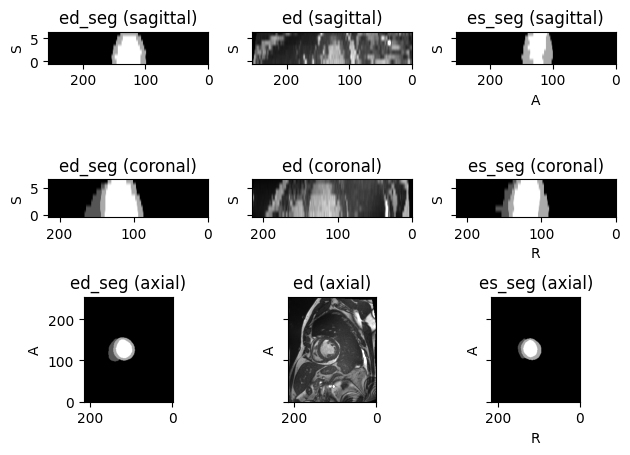

In [4]:
subject_a = tio.Subject(
    ed_seg=tio.ScalarImage('Train/053/053_ED_seg.nii'),
    ed = tio.ScalarImage('Train/053/053_ED.nii'),
    es_seg = tio.ScalarImage('Train/053/053_ES_seg.nii'),
)

subject_a.plot()


In [5]:
subject_a.ed_seg.data.shape

torch.Size([1, 216, 256, 7])

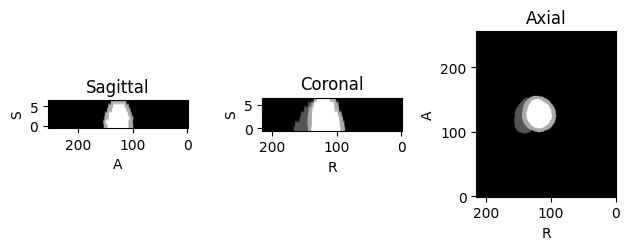

In [6]:
subject_a.ed_seg.plot()

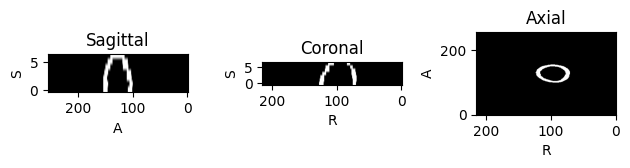

In [7]:
mask = np.where(subject_a.ed_seg.data == 2, True, False)
image = np.where(mask, subject_a.ed_seg.data, 0)

affine = 100*np.array([[2, 0, 0, -40],
                   [0, 1, 0, -10],
                   [0, 0, 10, -10],
                   [0, 0, 0, 1]])
scalar = tio.ScalarImage(tensor = image, affine = affine)
scalar.plot()

In [8]:
from scipy.ndimage import distance_transform_edt

dist = distance_transform_edt(image)
max_dist = 2*dist.max()

dist[dist>0].std(), max_dist, dist.shape

(0.5695417698512821, 7.483314773547883, (1, 216, 256, 7))

In [9]:
200*200

40000

In [18]:
import cv2 as cv

"""def thickness_myo(binary_img_seg):
    binary_img_seg = binary_img_seg.data.numpy()[0].astype(np.uint8)
    binary_img_seg = np.where(binary_img_seg == 2, 255, 0).astype(np.uint8)
    thickness = np.zeros(binary_img_seg.shape[2])
    for k in range (binary_img_seg.shape[2]):
        dist_transform = cv.distanceTransform(binary_img_seg[:,:,k].astype(np.uint8), cv.DIST_L2, 5)
        thickness[k] = dist_transform.max() - dist_transform.min()

    return np.mean(thickness), np.max(thickness)"""


def thickness_myo(binary_img_seg, voxel_size = (1,1,1)):

    binary_img_seg = binary_img_seg.data.numpy()[0].astype(np.uint8)
    binary_img_seg = np.where(binary_img_seg == 2, 255, 0).astype(np.uint8)    
    thickness = np.zeros(binary_img_seg.shape[2])

    for k in range (binary_img_seg.shape[2]):
        
        dist_transform = cv.distanceTransform(binary_img_seg[:,:,k], cv.DIST_L2, 5) * (np.sqrt(voxel_size[0] + voxel_size[1]))
        thickness[k] = (dist_transform.max() - dist_transform.min()) 

    return np.mean(thickness), np.max(thickness)

def extract_every(subject_dataset):
    all_thickness = np.zeros((len(subject_dataset), 4))

    for i in range(len(subject_dataset)):
        print("computing ", i)

        ed_seg = subject_dataset[i].ed_seg
        es_seg = subject_dataset[i].es_seg
        voxel_size = ed_seg.spacing

        thickness_ed = thickness_myo(ed_seg, voxel_size)
        thickness_es = thickness_myo(es_seg, voxel_size)

        all_thickness[i, :] = np.concatenate((thickness_ed, thickness_es))

    return all_thickness


In [22]:
metaData = pd.read_csv('metaDataTrain.csv')
metaDataClean = metaData.iloc
train_subject_dataset = load_test_dataset()

In [23]:
thickness_train = extract_every(train_subject_dataset)

computing  0
computing  1
computing  2
computing  3
computing  4
computing  5
computing  6
computing  7
computing  8
computing  9
computing  10
computing  11
computing  12
computing  13
computing  14
computing  15
computing  16
computing  17
computing  18
computing  19
computing  20
computing  21
computing  22
computing  23
computing  24
computing  25
computing  26
computing  27
computing  28
computing  29
computing  30
computing  31
computing  32
computing  33
computing  34
computing  35
computing  36
computing  37
computing  38
computing  39
computing  40
computing  41
computing  42
computing  43
computing  44
computing  45
computing  46
computing  47
computing  48
computing  49


In [20]:
df = pd.read_csv("metaDataTest2.csv")
new = pd.DataFrame(thickness_train, columns = ['ed_mean', 'ed_max','es_mean', 'es_max'])
df = pd.concat([df, new], axis=1)
df.to_csv("metaDataTest2.csv", index=False)

In [21]:
df = pd.read_csv("metaDataTest2.csv")
num_cols = len(df.columns)
df = df.iloc[:, 0:3]

df.to_csv("metaDataTest2.csv", index=False)